In [ ]:
from river.datasets import synth
from clustream import CluStream
from river import drift
import math
import numpy as np
import matplotlib.pyplot as plt
from river.utils import dict2numpy
from scipy.spatial import distance_matrix
from time import time
from river import stream
import pandas as pd
from scipy.spatial import distance_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
import itertools




In [111]:
win = 10
mc = 30
speed = 100

In [112]:
ds = pd.read_csv('./datasets/rbf create delete 1/rbf_create_delete_1.csv')

df = ds.copy()
y = df.pop('.class')
df.head()

,X1,X2
0,0.683742,0.537577
1,0.755625,0.547842
2,0.281957,0.696259
3,0.233024,0.675444
4,0.096462,0.153675


In [113]:
model = CluStream(n_macro_clusters=3,max_micro_clusters=mc,micro_cluster_r_factor=0.01,time_window=win,time_gap=500)
test = drift.PageHinkley(min_instances=10,delta=0.04899,threshold=0.15,alpha=1,mode='up')
output_drift = open(f'drift speed {speed}_{win}_{mc}.txt','+w')

0.020997333197270197
0.04786136396612879
0.04790803731441651
0.04673641352844392
0.045289381244676304
0.04537696927440294
0.04499118054189658
0.04577353725287197
0.04828591808702884
0.04805048393236753
0.045443764507003076
0.045703685155793414
0.04530076893034087
0.04801759953746264
0.04652619578384485


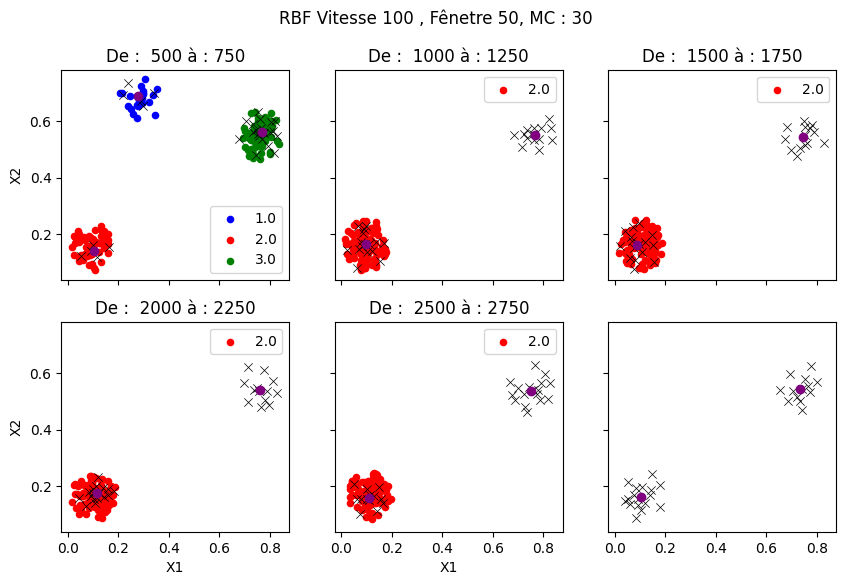

In [114]:
fig ,ax = plt.subplots(2,3,figsize=(10,6),sharex=True, sharey= True)
it = itertools.product((0,1,2),(0,1,2))
colors = {1 : 'blue', 2 : 'red', 3 : 'green', 4 : 'purple' , 5 : 'cyan', 6 : 'orange' , 7 : 'yellow', 8 : 'black' }
i = 0
j = 0
go = True
dist = []
mean_dist = []
drift_inst = []
for x,y in stream.iter_pandas(df,y):
    model = model.learn_one(x)
    i +=1

    if model._initialized :
        if go :
            model.offline_cluster()
            go = False

        test = test.update(model.dist_center(x))

        if test.drift_detected :
             print(f'Drift detected at instance: {i} ')
             output_drift.write(f'Drift detected at instance: {i}\n')
             drift_inst.append(i)
             ###Everything plays here
             #model.offline_cluster()

        dist.append(model.dist_center(x))
        if j % 200 == 0:
            print(np.mean(dist))
            mean_dist.append(np.mean(dist))
            dist = []
        j += 1

    if i % 500 == 0 :
        model.offline_cluster()
        k,m = next(it)
        centroids = model.get_micro_clusters()
        grouped = ds[i:i+250].groupby('.class')
        for key,group in grouped :
            group.plot(ax=ax[k,m],x='X1',y='X2',kind="scatter",label = key,color=colors[key],title=f'De :  {i} à : {i + 250}')
        ax[k,m].scatter(centroids[:,0],centroids[:,1],marker="x",c='black',linewidth=0.5)
        ax[k,m].scatter(model.centers[:,0],model.centers[:,1],marker='o',c='purple')
    
    if i ==3000 :
        break
    
    
        
fig.suptitle(f'RBF Vitesse {speed} , Fênetre {win}, MC : {mc}', fontsize=12)
fig.savefig(f'window_{win}_{mc}mc')

In [ ]:
for i,x in enumerate(drift_inst) : 
    drift_inst[i] = [x,np.interp(x,np.arange(200,3200,200),mean_dist)]
drift_inst = np.array(drift_inst)


In [ ]:
fig1 = plt.figure('Fig 2')
plt.plot(np.arange(200,3200,200),mean_dist)
plt.scatter(drift_inst[:,0],drift_inst[:,1],c='red',label='Points de drift')
plt.xlabel('Instance')
plt.ylabel('Distance min du centroid')
plt.title('Variation de la distance moyenne au centroids ')
plt.legend()

fig1.suptitle(f'RBF Vitesse {speed} , Fênetre {win}, MC : {mc}', fontsize=12)
fig1.savefig(f'drift_{win}_{mc}mc')
output_drift.close()